In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys

sys.path.append("../..")
import numpy as np
import tensorflow as tf
import random
from Bio import SeqIO

import evoten

2025-05-07 12:24:19.544388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 12:24:19.748644: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 12:24:19.808597: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 12:24:20.178502: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 12:24:20.955416: W tensorflow/compiler/tf2

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [3]:
# generate some sample data
def generate_data(n=1000, chain_tree=False, msa_length=100):
    msa = np.random.randint(0, 20, (n, msa_length), dtype=np.int32)
    if chain_tree:
        tree_newick = generate_chain_tree_newick(n)
    else:
        tree_newick = generate_random_tree_newick(n)
    tree_handler = evoten.TreeHandler.from_newick(tree_newick)
    return msa, tree_handler


def generate_chain_tree_newick(n):
    """
    Generates a Newick string for a chain tree with n nodes.
    The tree has nodes 1, 2, ..., n and edges (i, i+1).

    Args:
        n (int): Number of nodes in the chain tree.

    Returns:
        str: Newick string representing the chain tree.
    """
    if n < 1:
        raise ValueError("Number of nodes must be at least 1.")
    
    # Start building the Newick string
    newick = ""
    for i in range(1, n + 1):
        newick += f"({i}"
    newick += ")" * n + ";"
    return newick


def generate_random_tree_newick(num_nodes):
    """
    Generates a random tree as a Newick string with exactly the given number of 
    leaves. The tree is not necessarily binary.

    Args:
        num_leaves (int): Number of leaves in the tree.

    Returns:
        str: Newick string representing the random tree.
    """
    if num_nodes < 2:
        raise ValueError("The tree must have at least 2 nodes.")

    # Initialize nodes as a list of leaf nodes
    nodes = [f"{i}" for i in range(1, num_nodes + 1)]

    # Randomly combine nodes into a tree
    while len(nodes) > 1:
        # Randomly decide how many nodes to combine (at least 2)
        num_to_combine = random.randint(2, min(4, len(nodes)))  # Combine 2 to 4 nodes
        selected_indices = sorted(random.sample(range(len(nodes)), num_to_combine), reverse=True)
        selected_nodes = [nodes[i] for i in selected_indices]

        # Remove the selected nodes from the list in descending order
        for i in selected_indices:
            nodes.pop(i)

        # Generate a new parent node
        new_node = f"({','.join(selected_nodes)})"

        # Add the new node back to the list
        nodes.append(new_node)

    # The last remaining node is the root
    return nodes[0] + ";"

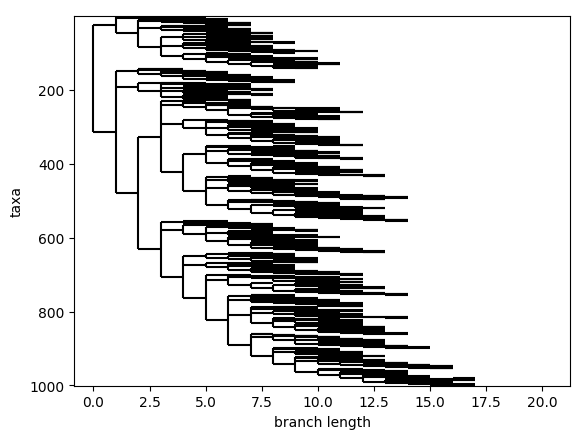

In [4]:
msa, tree_handler = generate_data(1000, chain_tree=False)
n, h = tree_handler.num_nodes, tree_handler.height
_, chained_tree_handler = generate_data(n-1, chain_tree=True)
tree_handler.draw(no_labels=True)

In [5]:
tree_handler.num_nodes, tree_handler.num_leaves, tree_handler.height

(1500, 1000, 17)

In [6]:
chained_tree_handler.num_nodes, chained_tree_handler.num_leaves, chained_tree_handler.height

(1500, 1, 1499)

In [7]:
# parse fasta
import evoten.model

msa_input = np.eye(20)[msa]
msa_input = msa_input[:, np.newaxis] # model dimension
msa_input = msa_input.astype(np.float32)

In [8]:
num_models = 10
# generate branch lengths of shape (num_nodes-1, num_models, 1)
branch_lengths = np.random.uniform(0.1, 1.0, size=(tree_handler.num_nodes - 1, num_models, 1))
branch_lengths = branch_lengths.astype(np.float32)

### TensorFlow

In [9]:
evoten.set_backend("tensorflow")

In [10]:
R, pi = evoten.substitution_models.jukes_cantor(d = 20)
rate_matrix = evoten.model.backend.make_rate_matrix(R, pi).numpy()
rate_matrix = rate_matrix[tf.newaxis, :, tf.newaxis,...] # add node and length dimensions

I0000 00:00:1746613464.150378    3522 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746613464.246047    3522 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746613464.246302    3522 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746613464.249744    3522 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [11]:
#wrap in tf function for speed
@tf.function
def loglik():
    transition_probs = evoten.backend.make_transition_probs(
        rate_matrix, 
        branch_lengths
    )
    return evoten.model.loglik(
        msa_input, 
        tree_handler, 
        transition_probs,
        tf.math.log(pi)
    )

In [12]:
#wrap in tf function for speed
@tf.function
def loglik_chained():
    transition_probs = evoten.backend.make_transition_probs(
        rate_matrix, 
        branch_lengths
    )
    return evoten.model.loglik(
        msa_input[:1], # we have just a single leaf 
        chained_tree_handler, 
        transition_probs,
        tf.math.log(pi)
    )

In [13]:
_=loglik() # compile
_=loglik_chained() # compile

2025-05-07 12:24:28.059771: I tensorflow/core/util/cuda_solvers.cc:178] Creating GpuSolver handles for stream 0x5a46401ce680


In [14]:
%%timeit -n 10
    _=loglik()

12.9 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%%timeit -n 10
    _=loglik_chained()

903 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Pytorch

In [16]:
evoten.set_backend("pytorch")

In [17]:
import torch 

R, pi = evoten.substitution_models.jukes_cantor(d = 20)
rate_matrix_torch = evoten.model.backend.make_rate_matrix(R, pi).to("cuda")
rate_matrix_torch = rate_matrix_torch[None, :, None,...] # add node and length dimensions

pi_torch = torch.tensor(pi, device="cuda")
msa_input_torch = torch.tensor(msa_input, device="cuda")
branch_lengths_toch = torch.tensor(branch_lengths, device="cuda")

In [18]:
def loglik_torch():
    transition_probs_torch = evoten.backend.make_transition_probs(
        rate_matrix_torch, 
        branch_lengths_toch
    )
    L = evoten.model.loglik(
        msa_input_torch, 
        tree_handler, 
        transition_probs_torch,
        torch.log(pi_torch)
    )
    return L

In [19]:
def loglik_torch_chained():
    transition_probs_torch = evoten.backend.make_transition_probs(
        rate_matrix_torch, 
        branch_lengths_toch
    )
    L = evoten.model.loglik(
        msa_input_torch[:1], # we have just a single leaf
        chained_tree_handler, 
        transition_probs_torch,
        torch.log(pi_torch)
    )
    return L

In [20]:
_=loglik_torch()
_=loglik_torch_chained()

In [21]:
%%timeit -n 10
loglik_torch()

15.5 ms ± 14.8 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit -n 10
loglik_torch_chained()

1.37 s ± 216 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
